In [45]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pywt
import pykitti

# Change this to the directory where you store KITTI data
basedir = ''

# Specify the dataset to load
date = '2011_09_26'
drive = '0019'

# Load the data. Optionally, specify the frame range to load.
dataset = pykitti.raw(basedir, date, drive, frames=[1])

In [46]:
# Point cloud data
point_cloud = dataset.get_velo(0)  # replace with your point cloud data

image_height = 64   # elevation resolution
image_width = 360   # azimuth resolution

# Initialize depth image with infinity (or some max range value)
depth_image = np.full((image_height, image_width), np.inf)

# Sensor-specific min and max elevation angles (these can vary based on LiDAR model)
min_elevation = -24.9 * np.pi / 180  # lower bound in radians
max_elevation = 2.0 * np.pi / 180    # upper bound in radians

for point in point_cloud:
    x, y, z = point[:3]
    
    # Polar coordinates
    r = np.sqrt(x**2 + y**2 + z**2)     # depth
    θ = np.arctan2(y, x)                # azimuth angle
    φ = np.arctan2(z, np.sqrt(x**2 + y**2))  # elevation angle

    # Map angles to pixel coordinates
    x_pixel = int((θ + np.pi) / (2 * np.pi) * image_width)
    y_pixel = int((φ - min_elevation) / (max_elevation - min_elevation) * image_height)

    x_pixel = min(max(x_pixel, 0), image_width - 1)
    y_pixel = min(max(y_pixel, 0), image_height - 1)
    # Update depth image, keeping closest depth
    if r < depth_image[y_pixel, x_pixel]:
        depth_image[y_pixel, x_pixel] = r

print("total pixels", np.prod(depth_image.shape))
print("num zero pixels", np.sum(depth_image == np.inf))

# Replace infinity values with 0 or a max range for visualization
depth_image[depth_image == np.inf] = 0


total pixels 23040
num zero pixels 4714


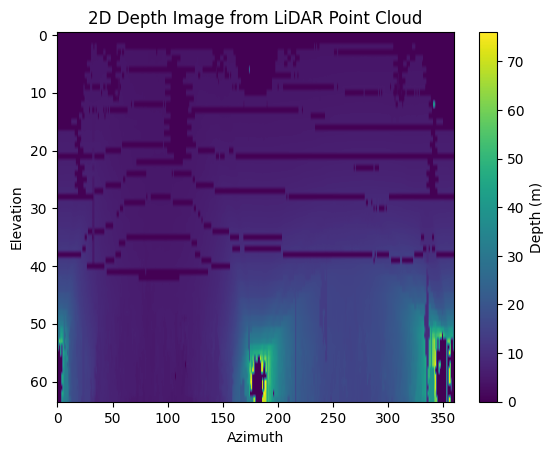

In [47]:
import matplotlib.pyplot as plt

plt.imshow(depth_image, cmap='viridis', aspect='auto')
plt.colorbar(label='Depth (m)')
plt.xlabel('Azimuth')
plt.ylabel('Elevation')
plt.title('2D Depth Image from LiDAR Point Cloud')
plt.show()

In [48]:
# Plot and compare two images
def compare_image(im1, im2, titles):
    plt.figure(figsize=(10, 5))
    plt.subplot(121); plt.imshow(im1, cmap='gray'); plt.title(titles[0]); plt.axis("off")
    plt.subplot(122); plt.imshow(im2, cmap='gray'); plt.title(titles[1]); plt.axis("off")
    plt.show()

def image_undersampling(img, undersampling_ratio):
    # number of total pixels
    n = np.prod(img.shape)
    # number of non-zero pixels
    m = int(undersampling_ratio * n)
    # undersampled image
    img_undersampled = np.zeros_like(img) 
    index_sample = np.random.choice(n, m, replace=False) 
    img_undersampled.flat[index_sample] = img.flat[index_sample].copy()
    return img_undersampled

# Transform to wavelet domain
def flat_wavelet_transform2(x):
    # input: image
    # output: image in the wavelet domain
    coeffs = pywt.wavedec2(x, 'sym3')
    x_transform = coeffs[0].reshape(-1)
    for tups in coeffs[1:]:
        for c in tups:
            x_transform = np.concatenate((x_transform, c.reshape(-1)))
    return x_transform

# Inverse transform to original domain
def inverse_flat_wavelet_transform2(x, shape):
    # input: image in the wavelet domain, image shape in the original domain
    # output: image
    shapes = pywt.wavedecn_shapes(shape, 'sym3')
    nx, ny = shapes[0][0], shapes[0][1]
    n = nx * ny
    coeffs = [x[:n].reshape(nx,ny)]
    for _, d in enumerate(shapes[1:]):
        vals=list(d.values())
        nx, ny = vals[0][0], vals[0][1]
        coeffs.append((x[n:n+nx*ny].reshape(nx, ny), x[n+nx*ny:n+2*nx*ny].reshape(nx, ny), x[n+2*nx*ny:n+3*nx*ny].reshape(nx, ny)))
        n += 3*nx*ny
    return pywt.waverec2(coeffs, 'sym3')

def l1_error_function(img1, img2):
    # INPUT:
    # img1 - ground truth image
    # img2 - reconstructed image
    # OUTPUT:
    # l1_error - l1-norm of the difference between img1 and img2
    l1_error = sum(abs(img1.reshape(-1)-img2.reshape(-1)))
    return l1_error

def recover_l1(y, lam):
    # INPUT:
    # y - noisy measurement
    # lam - weight which is the lambda in the formulation
    # OUTPUT:
    # x_l1 - recovered signal
    x_l1 = np.zeros(y.shape)+(y+lam)*(y<-lam)+(y-lam)*(y>lam)
    return x_l1

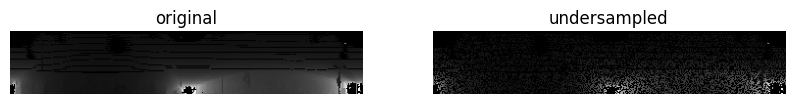

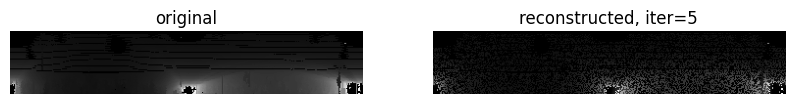

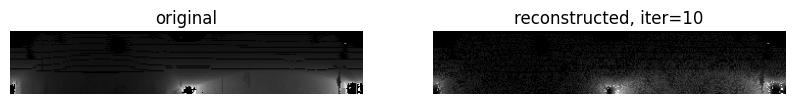

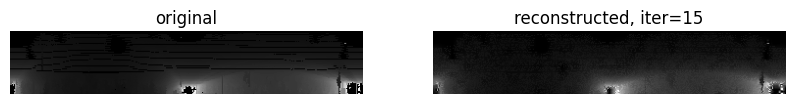

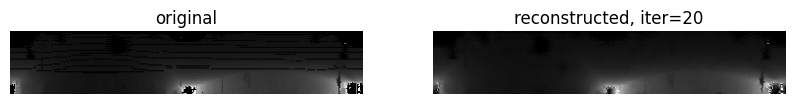

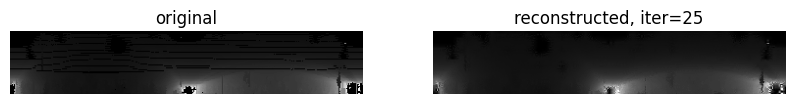

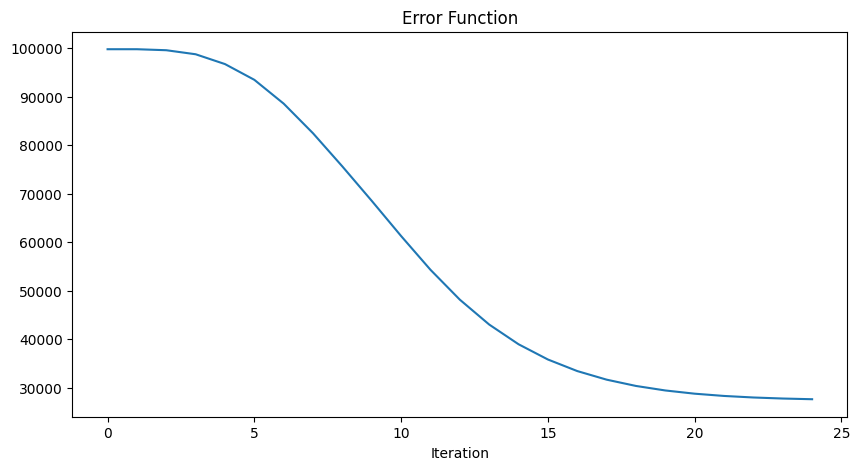

In [49]:
def compressive_sensing(img, undersampling_ratio, iter, lam, lam_decay, error_function, plot_process=True, plot_error=False):
    # INPUT:
    # img - ground truth image
    # undersampling_ratio - same as in image_undersampling
    # iter - number of iterations that alternatingly update the reconstruction
    # lam - same as in recover_l1
    # lam_decay - a decay factor that is applied to lam after each iteration
    # error_function - function that characterizing performance
    # plot_process - plot the reconstruction images as the algorithm iterate if TRUE
    # plot_error - plot the error curve if TRUE
    # OUTPUT:
    # plot reconstructed images and errors

    err = []
    # prepare the undersampled image
    image_undersampled = image_undersampling(img, undersampling_ratio)
    image_reconstructed = image_undersampled.copy()
    if plot_process == True:
        compare_image(img, image_reconstructed, titles=['original', 'undersampled'])
        
    for i in range(iter):
        # use flat_wavelet_transform2 (given in the beginning of the notebook) to transform the image to wavelet domain
        image_reconstructed_transformed = flat_wavelet_transform2(
                                image_reconstructed)
        # use recover_l1 to recover the signal with l1 penalty
        image_reconstructed_transformed_recovered = recover_l1(
                                image_reconstructed_transformed, lam)
        # use inverse_flat_wavelet_transform2 (given in the beginning of the notebook) to transform the image to the original domain
        image_reconstructed = inverse_flat_wavelet_transform2(
                                image_reconstructed_transformed_recovered,
                                img.shape)
        # copy the non-zero pixels in image_undersampled back to image_reconstructed
        image_reconstructed[image_undersampled!=0] = image_undersampled[
                                image_undersampled!=0]
        # clip the image_reconstructed to a matrix that only has integer values between 0 and 255
        image_reconstructed = np.clip(image_reconstructed, 0, 255)
        # append the error using error_function to err (use error_function)
        err.append(error_function(img, image_reconstructed))
        # update lam by multiplying lam_decay
        lam *= lam_decay
        # plot comparison using compare_image every 5 iterations
        if (i+1)%5 == 0 and plot_process == True:
            compare_image(img, image_reconstructed, titles=['original', 
                                f'reconstructed, iter={i+1}'])

    # plot the convergence of the error
    if plot_error == True:
        plt.figure(figsize=(10, 5))
        plt.plot(err)
        plt.xlabel('Iteration')
        plt.title('Error Function')
        plt.show()

    return image_reconstructed


depth_recon = compressive_sensing(img=depth_image, undersampling_ratio=0.5, iter=25, lam=300, lam_decay=0.75, error_function=l1_error_function, plot_error=True)

In [50]:
# Initialize an empty list to store the point cloud
point_cloud_recon = []

# Iterate over each pixel in the depth image
for y_pixel in range(image_height):
    for x_pixel in range(image_width):
        # Get depth from the image
        r = depth_recon[y_pixel, x_pixel]
        if r == 0:  # Ignore points with zero depth (no data)
            continue
        
        # Convert pixel to angles
        θ = (x_pixel / image_width) * 2 * np.pi - np.pi  # Azimuth angle in range [-π, π]
        φ = (y_pixel / image_height) * (max_elevation - min_elevation) + min_elevation  # Elevation angle

        # Convert spherical coordinates (r, θ, φ) to Cartesian coordinates (x, y, z)
        x = r * np.cos(φ) * np.cos(θ)
        y = r * np.cos(φ) * np.sin(θ)
        z = r * np.sin(φ)

        # Append the 3D point to the point cloud list
        point_cloud_recon.append([x, y, z])

# Convert list to a NumPy array for further processing or visualization
point_cloud_recon = np.array(point_cloud_recon)

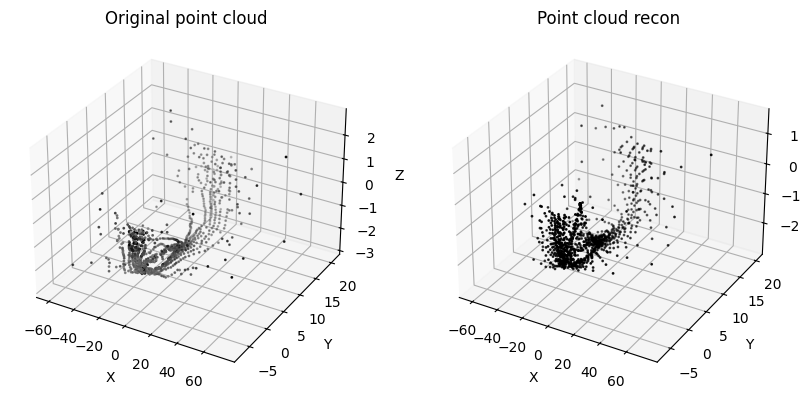

In [51]:
def plot_point_clouds(point_clouds, titles=None, point_size=1, color_map='gray'):
    """
    Plots multiple 3D point clouds in separate subplots.

    Parameters:
    - point_clouds: List of 3D point cloud arrays (each Nx3 or Nx4 if with intensity)
    - titles: List of titles for each subplot (optional)
    - point_size: Size of points in the scatter plot (optional, default=1)
    - color_map: Color map to use for point intensity (optional, default='gray')
    """
    num_clouds = len(point_clouds)
    fig = plt.figure(figsize=(5 * num_clouds, 5))
    
    for i, cloud in enumerate(point_clouds):
        ax = fig.add_subplot(1, num_clouds, i + 1, projection='3d')
        
        # Downsample points if needed for visualization
        step = max(1, cloud.shape[0] // 1000)  # Adjust to control display density
        sample_cloud = cloud[::step]
        
        if sample_cloud.shape[1] == 3:
            ax.scatter(sample_cloud[:, 0], sample_cloud[:, 1], sample_cloud[:, 2], 
                       s=point_size, c='black')  # No intensity values
        elif sample_cloud.shape[1] >= 4:
            ax.scatter(sample_cloud[:, 0], sample_cloud[:, 1], sample_cloud[:, 2], 
                       s=point_size, c=sample_cloud[:, 3], cmap=color_map)  # Use intensity for color

        # Set title if provided
        if titles and i < len(titles):
            ax.set_title(titles[i])
            
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

    plt.show()

plot_point_clouds([point_cloud, point_cloud_recon], ["Original point cloud", "Point cloud recon"])

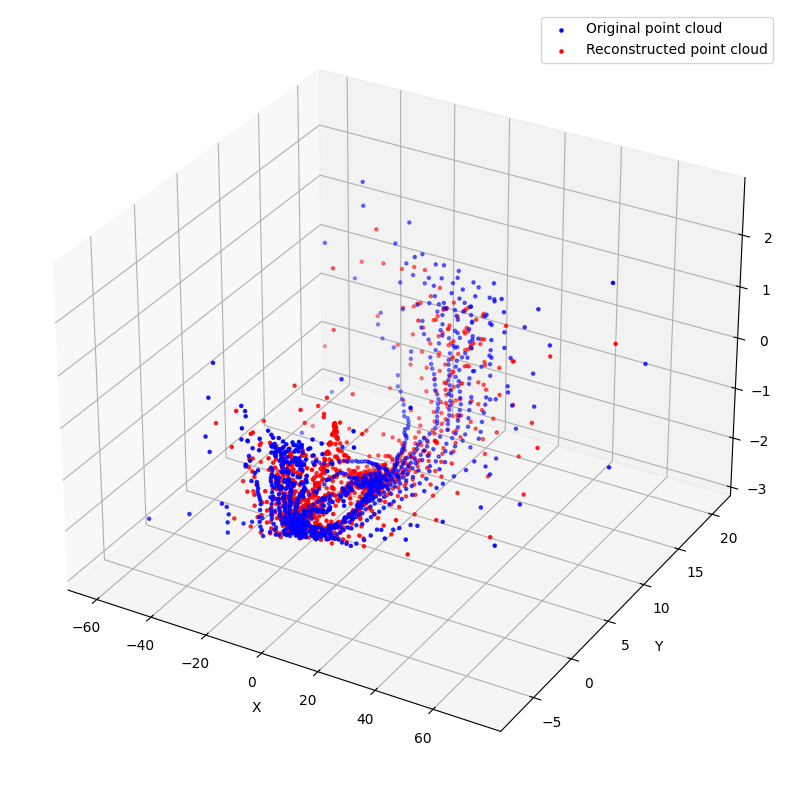

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_superimposed_point_clouds(point_clouds, labels=None, point_sizes=(5, 5), colors=('blue', 'red')):
    """
    Plots two superimposed 3D point clouds in a single plot with different colors.

    Parameters:
    - point_clouds: List of 3D point cloud arrays (each Nx3 or Nx4 if with intensity)
    - labels: List of labels for each point cloud (optional)
    - point_sizes: Tuple specifying the point sizes for each point cloud
    - colors: Tuple specifying colors for each point cloud
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    for i, cloud in enumerate(point_clouds):
        # Downsample points if needed for visualization
        step = max(1, cloud.shape[0] // 1000)  # Adjust to control display density
        sample_cloud = cloud[::step]

        # Plot with specified colors and sizes
        ax.scatter(
            sample_cloud[:, 0], sample_cloud[:, 1], sample_cloud[:, 2],
            s=point_sizes[i],
            color=colors[i],
            label=labels[i] if labels and i < len(labels) else None
        )

    # Set plot labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    if labels:
        ax.legend()

    plt.show()

# Example usage
plot_superimposed_point_clouds(
    [point_cloud, point_cloud_recon],
    labels=["Original point cloud", "Reconstructed point cloud"],
    point_sizes=(5, 5),  # You can increase these values for larger points
    colors=('blue', 'red')
)


In [53]:
from scipy.spatial import cKDTree

def chamfer_distance(point_cloud1, point_cloud2):
    """
    Computes the Chamfer Distance between two point clouds.

    Parameters:
    - point_cloud1: Nx3 numpy array of points (first point cloud)
    - point_cloud2: Mx3 numpy array of points (second point cloud)

    Returns:
    - chamfer_dist: Chamfer Distance between point_cloud1 and point_cloud2
    """
    # Build KD-trees for fast nearest-neighbor search
    tree1 = cKDTree(point_cloud1)
    tree2 = cKDTree(point_cloud2)
    
    # Nearest neighbor distances from each point in point_cloud1 to point_cloud2
    distances1, _ = tree1.query(point_cloud2)
    # Nearest neighbor distances from each point in point_cloud2 to point_cloud1
    distances2, _ = tree2.query(point_cloud1)
    
    # Average distances for both directions
    chamfer_dist = np.mean(distances1**2) + np.mean(distances2**2)
    return chamfer_dist


In [54]:
print(chamfer_distance(point_cloud[:, :3], point_cloud_recon))

0.36586172209364665
